In [5]:
import pandas as pd
import numpy as np

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [12]:
import sqlite3

conn = sqlite3.connect('../db.sqlite3')

cursor = conn.cursor()

cursor.execute("SELECT * FROM restaurant_orderitem;")
orderitems = cursor.fetchall()

cursor.execute("SELECT * FROM restaurant_product;")
products = cursor.fetchall()

cursor.execute("SELECT * FROM restaurant_order;")
orders = cursor.fetchall()

orderitems_df = pd.DataFrame(orderitems, columns=['id', 'quantity', 'order_id', 'product_id'])
products_df = pd.DataFrame(products, columns=['id', 'price', 'name'])
orders_df = pd.DataFrame(orders, columns=['id', 'datetime'])

merged_df = orderitems_df.merge(products_df, how='left', left_on='product_id', right_on='id')
merged_df = merged_df.merge(orders_df, how='left', left_on='order_id', right_on='id')

merged_df.to_csv("combined_data.csv", index=False)

df = pd.read_csv('combined_data.csv')

print(df.shape[0]) 

74818


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

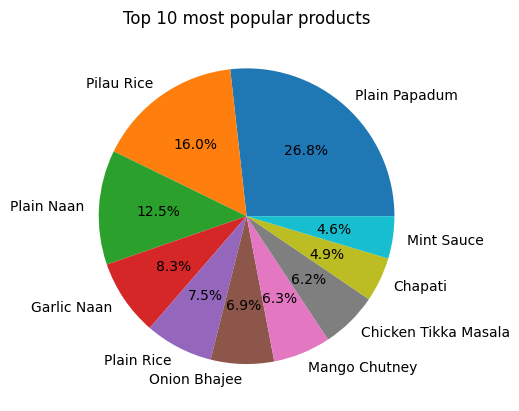

In [13]:
import matplotlib.pyplot as plt

grouped_df = df.groupby("name")["quantity"].sum().reset_index()

grouped_df = grouped_df.sort_values("quantity", ascending=False).head(10)

plt.pie(grouped_df["quantity"], labels=grouped_df["name"], autopct='%1.1f%%')
plt.title("Top 10 most popular products")
plt.show()

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

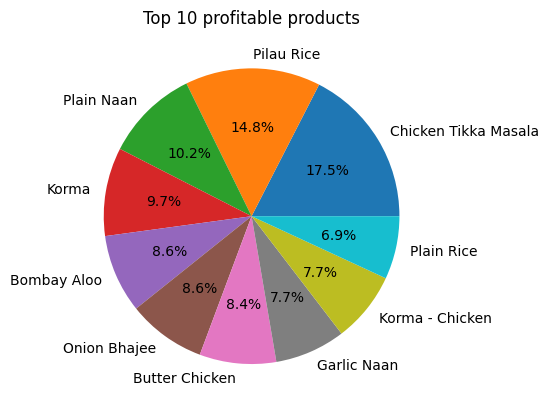

In [14]:
df['item_price'] = df['quantity'] * df['price']

grouped_df = df.groupby('name')['item_price'].sum().reset_index()

grouped_df = grouped_df.sort_values('item_price', ascending=False).head(10)

plt.pie(grouped_df['item_price'], labels=grouped_df['name'], autopct='%1.1f%%')
plt.title("Top 10 profitable products")
plt.show()

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

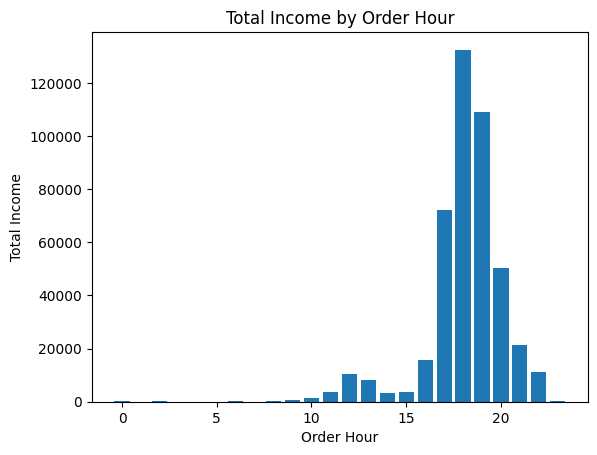

In [15]:
df['datetime'] = pd.to_datetime(df['datetime'])

df['order_hour'] = df['datetime'].dt.hour

grouped_df = df.groupby('order_hour')['item_price'].sum().reset_index()

plt.bar(grouped_df['order_hour'], grouped_df['item_price'])
plt.xlabel('Order Hour')
plt.ylabel('Total Income')
plt.title('Total Income by Order Hour')
plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

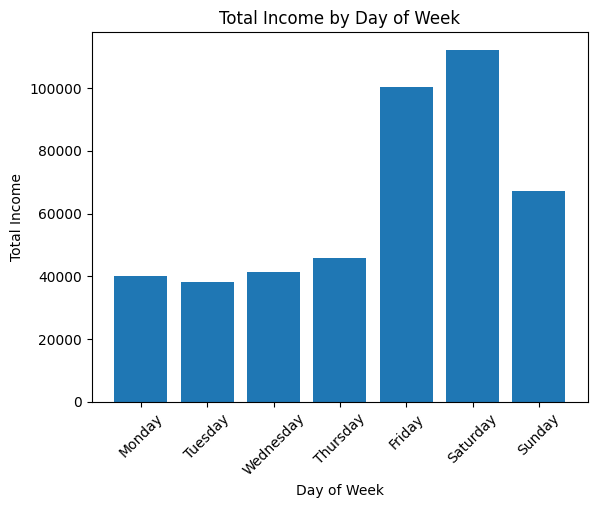

In [16]:
df['day_of_week'] = df['datetime'].dt.dayofweek

grouped_df = df.groupby('day_of_week')['item_price'].sum().reset_index()

days_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
grouped_df['day_of_week'] = grouped_df['day_of_week'].map(days_dict)

plt.bar(grouped_df['day_of_week'], grouped_df['item_price'])
plt.xlabel('Day of Week')
plt.ylabel('Total Income')
plt.title('Total Income by Day of Week')
plt.xticks(rotation=45)
plt.show()